In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import pickle as pk
from src.constants import emotions_faces,REF_PATH,MAPPING_PATH, E2V_PATH, W2V_PATH, DATA_PATH
import sys
sys.path.append("../../emoji2vec_working/")
from phrase2vec import Phrase2Vec
from src.data.form_eda import *
from src.data.fraudulous import *
from src.data.fraudulous import get_vec_error
import seaborn as sns
import numpy as np

sns.set()


/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

# Data Loading/Cleaning

In [2]:
# mapping from id to emoji
mapping = pk.load(open(MAPPING_PATH, 'rb'))
# mapping from emoji to id
inv_map = {v: k for k, v in mapping.items()}
phraseVecModel = Phrase2Vec.from_word2vec_paths(300, W2V_PATH, E2V_PATH)
e2v = phraseVecModel.emojiVecModel
w2v = phraseVecModel.wordVecModel

In [3]:
form1_df = read_form("../data/raw/forms/emoji10/Emojis Description.csv")
form2_df = read_form("../data/raw/forms/emoji10/Emoji Description 2.csv")
form3_df = read_form("../data/raw/forms/emoji10/Emoji Description 3.csv")

## Random User Inputs

<div class="alert alert-success"> 
Some entries are filled randomly by users ==> we want to find them "automatically". How to do detect fraudulous users? We analyze the classic behavior
</div>

In [4]:
# user labelled data
fraud1 = ["A3NKJAX21PSNWD","A2JC65REBH7706"]
fraud2 = ["A1A1PBGBNL11AW","A1KT0D8YWLHN71"]
fraud3 = ["A13T1DZG02HLNL","A12UREJ5PX9MT2","A30BSJVCI7M54I","A2S1M5UBIH0HTV"]
fraud = set(fraud1 + fraud2 + fraud3)

In [5]:
fraud1_df = form1_df.loc[fraud1]
fraud2_df = form2_df.loc[fraud2]
fraud3_df = form3_df.loc[fraud3]

In [6]:
fraud1_df

,🙂,😍,😀,😄,🤣,🤭,👿,🤔,🤯,😭
Worker ID,,,,,,,,,,
A3NKJAX21PSNWD,"star,blank,question","love,joy,enjou","smile,happy,enjoy","smile,happy,enjoy","blank,empty,thinking","blank,empty,thinking","angery,tension,avoid","blank,empty,thinking","blank,empty,thinking","funny,sad,feel"
A2JC65REBH7706,"sick,ill,unwell","love,smile,heart","fun,laughing,lol","happy,smiling,fun","sick,ill,unwell","sick,ill,unwell","monster,danger,angry","sick,ill,unwell","sick,ill,unwell","sad,cry,worry"


In [7]:
fraud2_df

,😗,😤,🙄,😱,😮,😶,😑,😒,😓,😵
Worker ID,,,,,,,,,,
A1A1PBGBNL11AW,"neutral,normal,fine","happy,enjoy,normal","happy,enjoy,nornal","sad,upset,normal","upset,normal,sad","sad,neutral,nice","unhappy,sad,neutral","sad,nice,happy","cry,sad,upset","normal,neutral,nice"
A1KT0D8YWLHN71,"nice,good,like","good,nice,super","good,simple,nice","bad,cry,struggle","surprise,shock,alur","noword,simple,peace","bad,sad,feelings","hate,dislike,angry","sad,cry,feelings","smilr,good,spark"


In [8]:
fraud3_df

,😊,😴,🤓,😥,🤢,😰,😂,😖,😞,😧,😔,😲
Worker ID,,,,,,,,,,,,
A13T1DZG02HLNL,"happy,independent,joy","sad,worry,failure","none,none,none","frustrating,worst,bad","none,none,none","smile,healthy,happy","smile,happy,healthy","happy,joy,enjoying","sad,worry,unluck","bored,waste,sad","sad,bored,waste","sad,failure,waste"
A12UREJ5PX9MT2,"smile,joy,hilarious","sad,emotional,cry","blank,box,nope","fear,panic,horror","box,blank,square","joy,happy,curious","cry,sad,emotional","fear,panic,sad","shock,panic,fear","shock,panic,fear","shock,panic,fear","shock,panic,fear"
A30BSJVCI7M54I,"sick,ill,understood","sick,ill,unwell","sick,ill,understood","sick,ill,cool","sick,unwell,ill","ideal,cool,happy","cool,happy,cool","cool,ill,unwell","sick,cry,desperate","sick,worry,sad","cool,calm,well","cool,ideal,understood"
A2S1M5UBIH0HTV,"smile,happy,normal","thinking,serious,angry","sad,bad,sick","cry,notgood,sad","bad,notgood,sad","smiling,laughing,happy","happy,exixited,laughing","sad,serious,thinking","sad,shocked,deceived","angry,shout,sick","silent,innocent,simple","smile,happy,exitinig"


<div class="alert alert-success"> 
We notice the following patterns:

<ul>
    <li>Many identical cells on same row (in terms of set) ex: sad,upset,normal vsnupset,normal,sad</li>
    <li>Three times the same word in a single cell</li>
    <li>General poor vocabulary</li>
    <li>No coherence with the emoji
        at all in terms of semantic meaning </li>

</ul>
</div>

### Constant answer

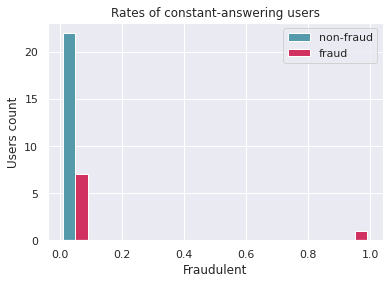

In [9]:
cstt = get_users_cstt([form1_df,form2_df,form3_df])
plot_double_hist(cstt,fraud)

<div class="alert alert-info"> 
Even if it represents a tiny amonunt of data, exclusively the fraudulous data ends up having constant cells.
</div>

### Recurrent Answer

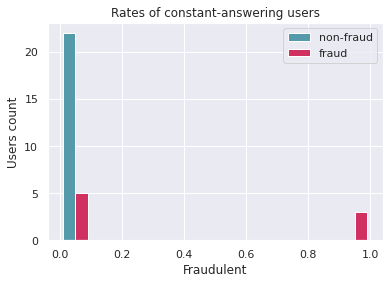

In [10]:
duplicate = get_users_duplicate([form1_df,form2_df,form3_df])
plot_double_hist(duplicate,fraud)

<div class="alert alert-info"> 
Same holds for recurrent answers.
</div>

### Voc size

No handles with labels found to put in legend.


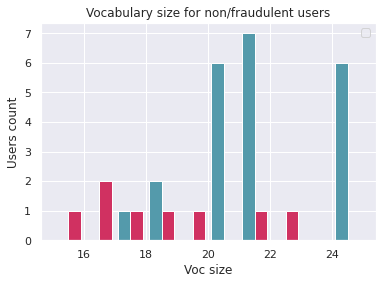

In [11]:
tot_voc = compute_voc_size([form1_df,form2_df,form3_df])
plot_voc(tot_voc,fraud)

<div class="alert alert-info"> 
We can get rid of a certain amount of frauders by thresholding at 16 (55% of max vocabulary size): indeed, the two distributions are spread enough to get rid of a significant part of the fraudulous data.
</div>

### Semantic Analysis

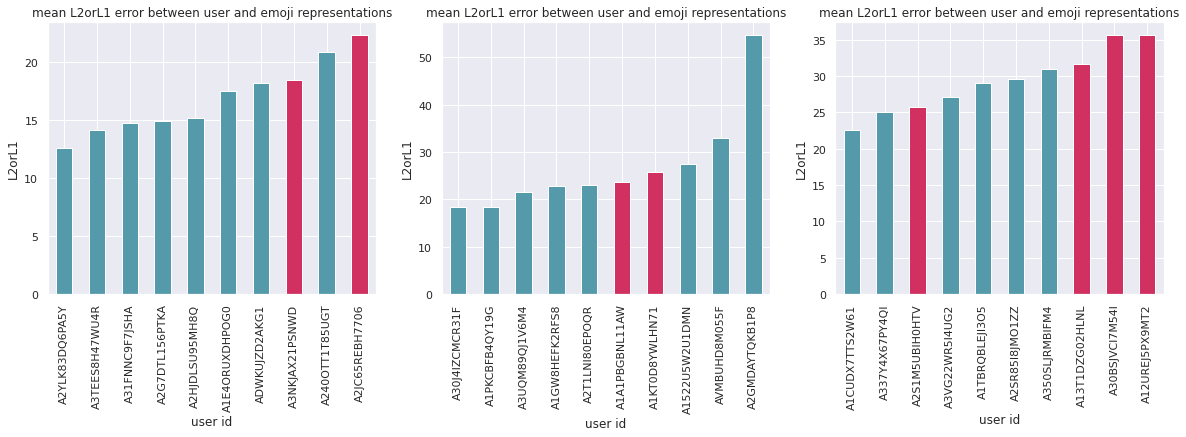

In [12]:
ref = "mean" # "mean" or "em"
loss = "l2" # "l2" or "l1"
fig,ax = plt.subplots(1,3,figsize=(20,5))

vec_error1 = get_vec_error(form1_df,w2v,e2v,ref=ref,loss=loss)
vec_error2 = get_vec_error(form2_df,w2v,e2v,ref=ref,loss=loss)
vec_error3 = get_vec_error(form3_df,w2v,e2v,ref=ref,loss=loss)

plot_vec_error(vec_error1,fraud,ax=ax[0])
plot_vec_error(vec_error2,fraud,ax=ax[1])
plot_vec_error(vec_error3,fraud,ax=ax[2])

<div class="alert alert-info"> 
Although some combinations might lead to decent classification, we don't observe the expected gap between the fraudulous and non fraudulous data. 
    
TODO: ASK==> any suggestion to find it?
</div>

## Fraudulous Detection

<div class="alert alert-success"> 
Now we have an idea of the feature of a fraud, we can try to filter our data
</div>

Accuracy:0.8333333333333334
Precision:1.0
Recall:0.375


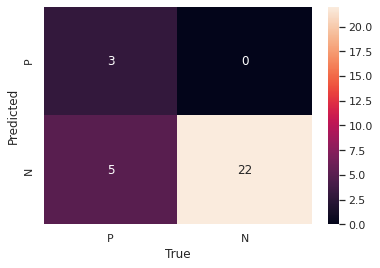

In [13]:
filter_funcs = [dtct_poor_voc,
                dtct_cstt_answer,
                dtct_duplicate_answer
]

fraud_hat = (set.union(find_fraudulous(form1_df,filter_funcs),
                       find_fraudulous(form2_df,filter_funcs),
                       find_fraudulous(form1_df,filter_funcs)))
users = gather_users(form1_df,form2_df,form3_df)

fraud_metrics(users,fraud,fraud_hat)

In [14]:
# random users answers
form1_df.drop(fraud1,inplace=True)
form2_df.drop(fraud2,inplace=True)
form3_df.drop(fraud3,inplace=True)

# Data Analysis

## Feature Extraction

<div class="alert alert-success"> 
We now extract the features from the words of the users using a word2vec instance. Each user representation for an emoji is obtained by averaging between the 3 words the user gave.
    <b>TODO: see if weighting this mapping gives something interesting</b>
</div>

In [15]:
# form1
user1_df = user_representation(form1_df,w2v)
unif1_df = unif_representation(form1_df,w2v)
# form2
user2_df = user_representation(form2_df,w2v)
unif2_df = unif_representation(form2_df,w2v)
# form3
user3_df = user_representation(form3_df,w2v)
unif3_df = unif_representation(form3_df,w2v)

## Clustering assessment

<div class="alert alert-success"> 
We try to assess how clustered/centered the data is in the small dataset we received.
</div>

Emojis:😭 🤣 😍 😀 🙂 👿 😄 🤯 🤭 🤔 Emojis:😱 😮 😤 😗 😑 😶 🙄 😓 😒 😵 Emojis:😴 🤢 😂 😧 😥 🤓 😊 😞 😲 😖 😰 😔 

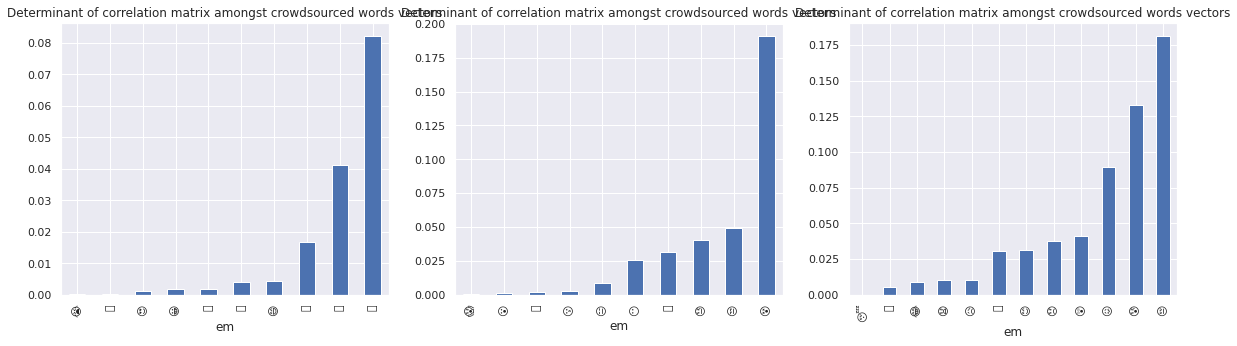

In [16]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
print_det(user1_df,ax[0])
print_det(user2_df,ax[1])
print_det(user3_df,ax[2])

Emojis:🙂 😭 🤣 👿 😍 😀 😄 🤯 🤭 🤔 Emojis:😱 😮 😗 😤 😶 😑 😓 🙄 😒 😵 Emojis:😴 🤢 😥 😧 😊 🤓 😂 😞 😲 😰 😖 😔 

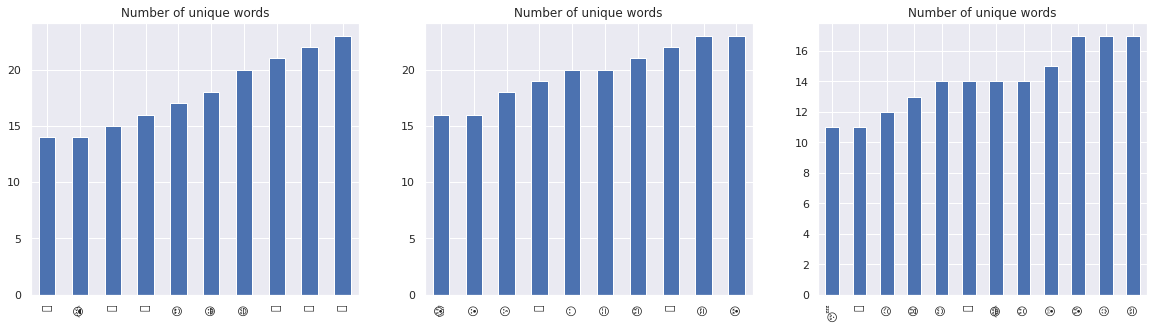

In [17]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
print_num_words(form1_df,ax=ax[0])
print_num_words(form2_df,ax=ax[1])
print_num_words(form3_df,ax=ax[2])

## Correlations with emoji2vec

<div class="alert alert-success"> 
We compute the correlation between the feature space created by taking the mean/median of the vectors corresponding to the crowd-sourced words: this allow us to check for which emoji a divergence can be observed
</div>

In [18]:
user1_df = user1_df[user1_df.index.isin(emotions_faces)]
user2_df = user2_df[user2_df.index.isin(emotions_faces)]
user3_df = user3_df[user3_df.index.isin(emotions_faces)]

In [19]:
# change inplace
compute_em2v_vecs(user1_df,e2v)
compute_em2v_vecs(user2_df,e2v)
compute_em2v_vecs(user3_df,e2v)

Emojis:🤔 🤣 👿 🙂 😀 😄 😍 😭 Emojis:😮 🙄 😑 😱 😤 😶 😓 😒 😗 😵 Emojis:😥 😖 😧 😔 😰 😊 🤓 😴 😞 😂 😲 🤢 

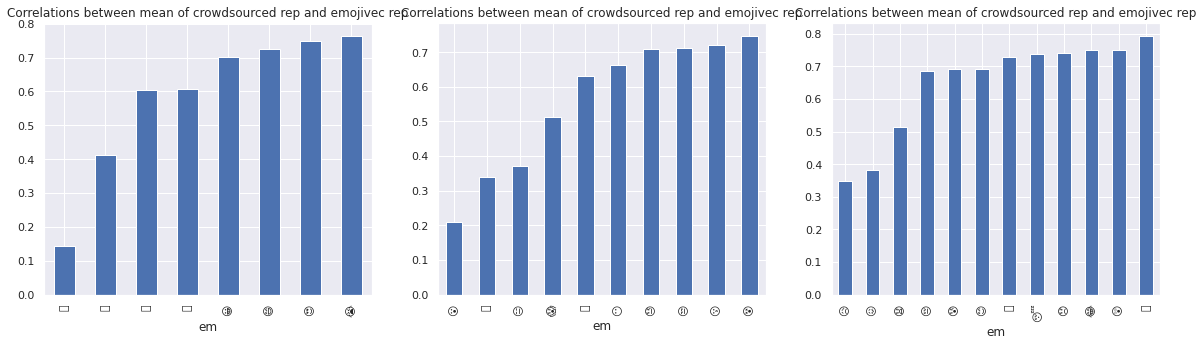

In [20]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
plot_corr(user1_df,ax=ax[0])
plot_corr(user2_df,ax=ax[1])
plot_corr(user3_df,ax=ax[2])

Emojis:🤔 🤣 👿 🙂 😀 😄 😍 😭 Emojis:😮 🙄 😑 😱 😤 😶 😒 😓 😵 😗 Emojis:😥 😖 😧 😊 😰 😔 😴 😞 🤓 😂 😲 🤢 

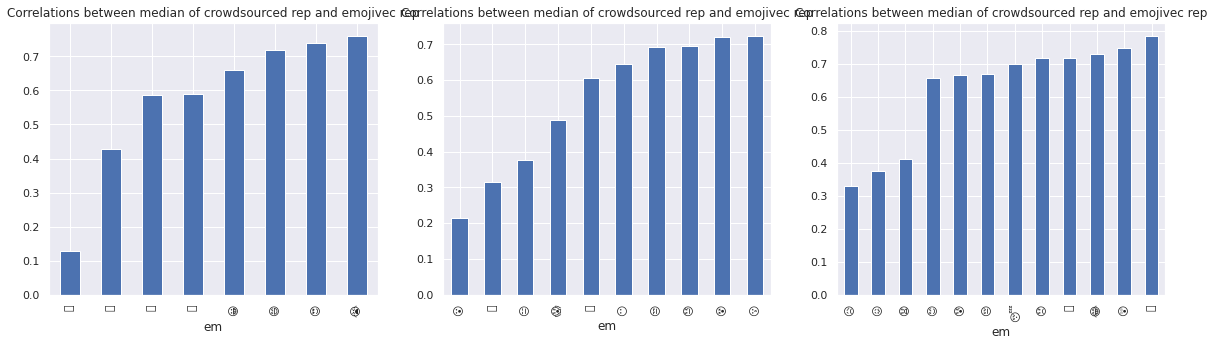

In [21]:
fig,ax = plt.subplots(1,3,figsize=(20,5))
plot_corr(user1_df,agg_type='median',ax=ax[0])
plot_corr(user2_df,agg_type='median',ax=ax[1])
plot_corr(user3_df,agg_type='median',ax=ax[2])

## Top representative words

<div class="alert alert-success"> 
We now try to assess which word is the closest to each emoji in the vector space in order <b>to better grasp the emotional representation of each emoji for the users.</b>
</div>

In [22]:
words_scores_meanvec_df1 = get_words_scores(form1_df,user1_df,w2v)
words_scores_em2vec_df1 = get_words_scores(form1_df,user1_df,w2v,col="em2vec_rep")

words_scores_meanvec_df2 = get_words_scores(form2_df,user2_df,w2v)
words_scores_em2vec_df2 = get_words_scores(form2_df,user2_df,w2v,col="em2vec_rep")

words_scores_meanvec_df3 = get_words_scores(form3_df,user3_df,w2v)
words_scores_em2vec_df3 = get_words_scores(form3_df,user3_df,w2v,col="em2vec_rep")

Emoji2vec representation:
Emoji 🤔:
Emoji 😗:
Emoji 🤓:


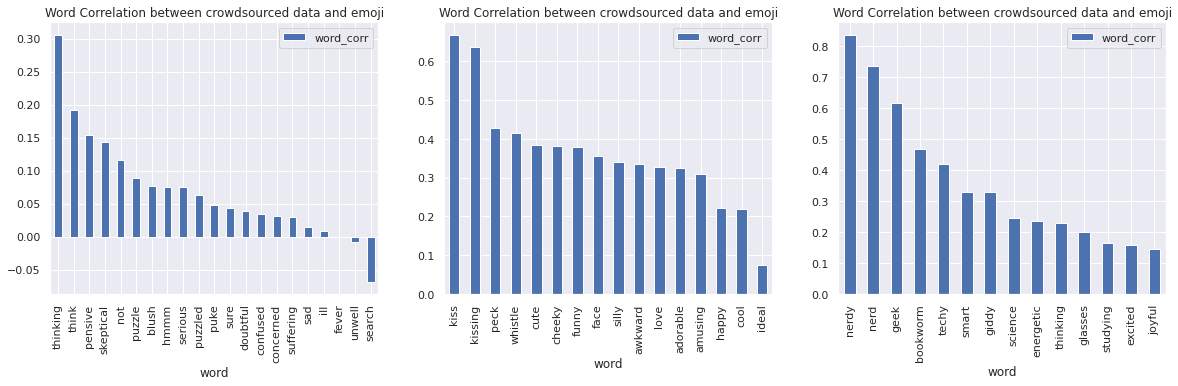

In [24]:
# list of emojis: 🙂😍😀😄🤣👿🤔😭
emoi1 = "🤔"
# list of emojis: 😗😤🙄😱😮😶😑😒😓😵
emoi2 = "😗"
# list of emojis: 😊😴🤓😥🤢😰😂😖😞😧😔😲
emoi3 = "🤓"

fig,ax = plt.subplots(1,3,figsize=(20,5))
print("Emoji2vec representation:")
col = "word_corr" # "word_corr" or "word_cossim"
plot_best_words_emojis(words_scores_em2vec_df1,em=emoi1,col=col,ax=ax[0])
plot_best_words_emojis(words_scores_em2vec_df2,em=emoi2,col=col,ax=ax[1])
plot_best_words_emojis(words_scores_em2vec_df3,em=emoi3,col=col,ax=ax[2])

Mean Crowdsourced data representation:
Mean Crowdsourced data representation:
Emoji 🤔:
Emoji 😗:
Emoji 🤓:


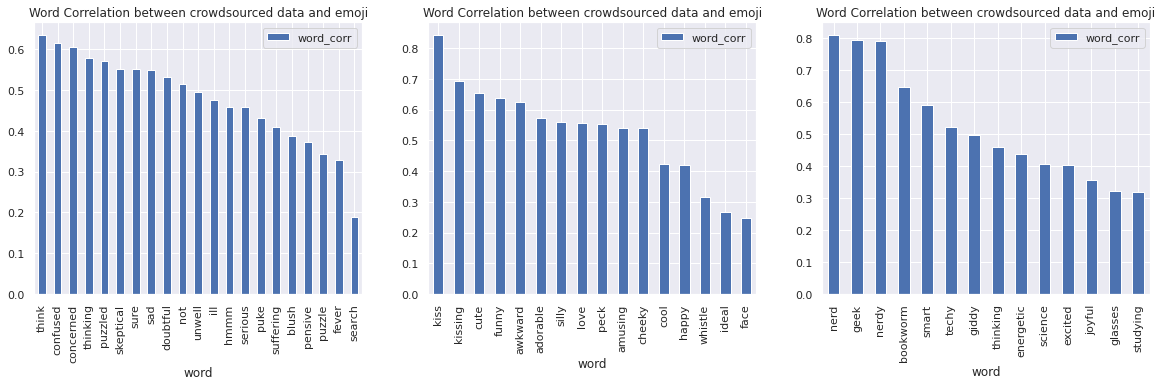

In [26]:
print("Mean Crowdsourced data representation:")
fig,ax = plt.subplots(1,3,figsize=(20,5))
print("Mean Crowdsourced data representation:")
plot_best_words_emojis(words_scores_meanvec_df1,em=emoi1,col=col,ax=ax[0])
plot_best_words_emojis(words_scores_meanvec_df2,em=emoi2,col=col,ax=ax[1])
plot_best_words_emojis(words_scores_meanvec_df3,em=emoi3,col=col,ax=ax[2])

## T-SNE update

<img src="../results/tsne/faces_tsne_words.jpeg"></div>